In [10]:
import sys
sys.path.append('./data_generated_library')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import credit_card_data

import torch.nn as nn
import torch
import torch.nn.functional as F
# from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## data generation

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
window_size = 30

Z,Y = credit_card_data.generate_raw_data(60, 10000)
train_data, train_label, test_data, test_label = credit_card_data.generate_win_data(Z, Y, window_size, 3)
train_data = torch.tensor(train_data, dtype=torch.float, device=device)
train_label = torch.tensor(train_label, dtype=torch.float, device=device)
test_data = torch.tensor(test_data, dtype=torch.float, device=device)
test_label = torch.tensor(test_label, dtype=torch.float)

In [13]:
print(train_label.size())
print(train_label.sum())

torch.Size([17842])
tensor(3021., device='cuda:0')


## ANN

In [14]:
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ANN, self).__init__()
        hidden_dim = input_dim // 2
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, input_data):
        l1 = self.linear1(input_data)
        l2 = self.linear2(l1)
        y_pred = nn.Sigmoid()(l2)
        return y_pred

In [15]:
ann_model = ANN(input_dim=window_size, output_dim=1)
ann_model.to(device)

learning_rate = 0.01
loss_fn = torch.nn.BCELoss(size_average=False)
optimiser = torch.optim.Adam(ann_model.parameters(), lr=learning_rate)

C:\Users\Administrator\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [17]:
num_epochs = 10
batch_size = 128

#ann_writer = SummaryWriter()
for t in range(num_epochs):
    # shuffle data
    idx = np.random.permutation(len(train_data))
    train_data = train_data[idx]
    train_label = train_label[idx]
    total_loss = 0
    for i in range(len(train_data)//batch_size):
        optimiser.zero_grad()
        batch_data = train_data[i*batch_size:(i+1)*batch_size]
        batch_label = train_label[i*batch_size:(i+1)*batch_size]
        y_pred = ann_model(batch_data)
        weight = 4 * (batch_label == 1).float() + torch.ones(batch_size, device=device)
        loss = torch.nn.BCELoss(weight=weight)(y_pred, batch_label)
        #ann_writer.add_scalar('ANN loss', loss, t * len(train_data)//batch_size +i)
        total_loss += loss
        loss.backward()
        optimiser.step()
    print("epoch {:d}: {}".format(t, total_loss/(len(train_data)//batch_size)))

C:\Users\Administrator\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


epoch 0: 1.0733692646026611
epoch 1: 1.0622234344482422
epoch 2: 1.0616931915283203
epoch 3: 1.060125708580017
epoch 4: 1.0601143836975098
epoch 5: 1.059453010559082
epoch 6: 1.0599565505981445
epoch 7: 1.0602545738220215
epoch 8: 1.0588845014572144
epoch 9: 1.0587363243103027


## LSTM

In [277]:
class LSTM(nn.Module):
    def __init__(self, output_dim, bidirectional=False):
        super(LSTM, self).__init__()
        self.input_dim = 1
        self.hidden_dim = 3
        self.num_layers = 2
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, bidirectional=bidirectional)
        self.linear = nn.Linear((bidirectional+1)*self.hidden_dim, output_dim)
    
    def forward(self, input_data):
        lstm_out, hidden = self.lstm(input_data.view(input_data.size()[0], input_data.size()[1], -1))
        linear = self.linear(lstm_out[-1])
        y_pred = nn.Sigmoid()(linear)
        return y_pred

In [278]:
lstm_model = LSTM(output_dim=1)
lstm_model.to(device)

learning_rate = 0.01
loss_fn = torch.nn.BCELoss(size_average=False)
optimiser = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

C:\Users\Administrator\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [279]:
num_epochs = 10
batch_size = 128

#lstm_writer = SummaryWriter()
for t in range(num_epochs):
    # shuffle data
    idx = np.random.permutation(len(train_data))
    train_data = train_data[idx]
    train_label = train_label[idx]
    total_loss = 0
    for i in range(len(train_data)//batch_size):
        optimiser.zero_grad()
        batch_data = train_data[i*batch_size:(i+1)*batch_size].permute(1,0)
        batch_label = train_label[i*batch_size:(i+1)*batch_size]
        y_pred = lstm_model(batch_data)
        weight = 4 * (batch_label == 1).float() + torch.ones(batch_size, device=device)
        loss = torch.nn.BCELoss(weight=weight)(y_pred, batch_label)
        #lstm_writer.add_scalar('LSTM loss', loss, t * len(train_data)//batch_size +i)
        total_loss += loss
        loss.backward()
        optimiser.step()
    print("epoch {:d}: {}".format(t, total_loss/(len(train_data)//batch_size)))

C:\Users\Administrator\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


epoch 0: 1.0763764381408691
epoch 1: 1.0492150783538818
epoch 2: 1.0481438636779785
epoch 3: 1.0471961498260498
epoch 4: 1.046142578125
epoch 5: 1.0474337339401245
epoch 6: 1.0469977855682373
epoch 7: 1.0477420091629028
epoch 8: 1.0463676452636719
epoch 9: 1.0465428829193115


## CNN

In [21]:
class CNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNN, self).__init__()
        kernel_size = 3
        self.input_dim = input_dim
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=3, kernel_size=kernel_size)
        self.conv2 = torch.nn.Conv1d(in_channels=3, out_channels=3, kernel_size=kernel_size)
        self.linear1 = nn.Linear((input_dim-2*(kernel_size-1))*3, 10)
        self.linear2 = nn.Linear(10, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input_data):
        conv_out1 = self.conv1(input_data.view(input_data.size()[0], 1, input_data.size()[1]))
        conv_out1 = nn.ReLU()(conv_out1)
        conv_out2 = self.conv2(conv_out1)
        conv_out2 = nn.ReLU()(conv_out2)
        linear1 = self.linear1(conv_out2.view(conv_out2.size()[0], -1))
        linear1 = nn.ReLU()(linear1)
        linear2 = self.linear2(linear1)
        y_pred = self.sigmoid(linear2)
        return y_pred

In [22]:
cnn_model = CNN(input_dim=window_size, output_dim=1)
cnn_model.to(device)

learning_rate = 0.01
loss_fn = torch.nn.BCELoss(size_average=False)
optimiser = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

C:\Users\Administrator\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [23]:
num_epochs = 10
batch_size = 128

#cnn_writer = SummaryWriter()
for t in range(num_epochs):
    # shuffle data
    idx = np.random.permutation(len(train_data))
    train_data = train_data[idx]
    train_label = train_label[idx]
    total_loss = 0
    for i in range(len(train_data)//batch_size):
        optimiser.zero_grad()
        batch_data = train_data[i*batch_size:(i+1)*batch_size]
        batch_label = train_label[i*batch_size:(i+1)*batch_size]
        y_pred = cnn_model(batch_data)
        weight = 4 * (batch_label == 1).float() + torch.ones(batch_size, device=device)
        loss = torch.nn.BCELoss(weight=weight)(y_pred, batch_label)
        #cnn_writer.add_scalar('CNN loss', loss, t * len(train_data)//batch_size +i)
        total_loss += loss
        loss.backward()
        optimiser.step()
    print("epoch {:d}: {}".format(t, total_loss/(len(train_data)//batch_size)))

C:\Users\Administrator\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


epoch 0: 1.1315727233886719
epoch 1: 1.0769551992416382
epoch 2: 1.0594671964645386
epoch 3: 1.0613855123519897
epoch 4: 1.0540087223052979
epoch 5: 1.0524218082427979
epoch 6: 1.0521076917648315
epoch 7: 1.0519952774047852
epoch 8: 1.0538777112960815
epoch 9: 1.0493279695510864


## LSTM + Attention

In [280]:
## Attention Layer
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim 
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)
        #print(a)
        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

In [281]:
class LSTM_ATT(nn.Module):
    def __init__(self, batch_size, seq_len, att_dim, output_dim=3):
        super(LSTM_ATT, self).__init__()
        self.input_dim = 1
        self.hidden_dim = 4
        self.batch_size = batch_size
        self.num_layers = 2
        self.seq_len = seq_len
        self.att_dim = att_dim
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.att = Attention(self.att_dim,2)
        self.linear_2 = nn.Linear(self.att_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input):
        lstm_out, hidden = self.lstm(input.view(input.size()[0],input.size()[1],-1))#;print(lstm_out.size())
        att_out = self.att(lstm_out[-2:].permute(1,0,2))#;print(att_out.size())
        output_2 = self.linear_2(att_out)#;print(output_2.size())
        y_pred_2 = self.sigmoid(output_2)
        return y_pred_2

In [287]:
att_dim = 4
output_dim = 1
lstm_att_model = LSTM_ATT(
    batch_size=batch_size, 
    seq_len = window_size,
    att_dim = att_dim,
    output_dim=output_dim
)
lstm_att_model.to(device)

learning_rate = 0.002
loss_fn = torch.nn.BCELoss(size_average=False)
optimiser = torch.optim.Adam(lstm_att_model.parameters(), lr=learning_rate)

C:\Users\Administrator\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [288]:
num_epochs = 10
batch_size = 128

#lstm_att_writer = SummaryWriter()
for t in range(num_epochs):
    # shuffle data
    idx = np.random.permutation(len(train_data))
    train_data = train_data[idx]
    train_label = train_label[idx]
    total_loss = 0
    for i in range(len(train_data)//batch_size):
        optimiser.zero_grad()
        batch_data = train_data[i*batch_size:(i+1)*batch_size].permute(1,0)
        batch_label = train_label[i*batch_size:(i+1)*batch_size]
        y_pred = lstm_att_model(batch_data)
        weight = 4 * (batch_label == 1).float() + torch.ones(batch_size, device=device)
        loss = torch.nn.BCELoss(weight=weight)(y_pred, batch_label)
        #lstm_att_writer.add_scalar('LSTM-ATT loss', loss, t * len(train_data)//batch_size +i)
        total_loss += loss
        loss.backward()
        optimiser.step()
    print("epoch {:d}: {}".format(t, total_loss/(len(train_data)//batch_size)))

C:\Users\Administrator\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


epoch 0: 1.1532530784606934
epoch 1: 1.094854712486267
epoch 2: 1.0542969703674316
epoch 3: 1.0502792596817017
epoch 4: 1.049325704574585
epoch 5: 1.0473493337631226
epoch 6: 1.0471315383911133
epoch 7: 1.0486257076263428
epoch 8: 1.0471223592758179
epoch 9: 1.0471783876419067


## Measure

In [265]:
def criteria(pred, label, threshold):
    recall = []
    precision = []
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    TP += ((pred > threshold).numpy().flatten()&(label == 1).numpy()).sum()
    TN += ((pred < threshold).numpy().flatten()&(label == 0).numpy()).sum()
    FP += ((pred > threshold).numpy().flatten()&(label == 0).numpy()).sum()
    FN += ((pred < threshold).numpy().flatten()&(label == 1).numpy()).sum()
    return TP, TN, FP, FN

def plot(pred, label, func, name):
    xs = []
    ys = []
    steps = 1000
    l, r = pred.min(), pred.max()
    for i in range(steps):
        t = l + (r - l) * i / steps
        x, y = func(pred, label, t)
        xs.append(x)
        ys.append(y)
    plt.plot(xs, ys,label = name)
    plt.xlim(0,1)
    plt.ylim(0,1)

In [266]:
def precision_recall(pred, label, threshold):
    TP, TN, FP, FN = criteria(pred, label, threshold)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    return recall, precision

def precision_recall_plot(pred, label, name = None):
    plot(pred, label, precision_recall, name)

In [267]:
def ROC(pred, label, threshold):
    TP, TN, FP, FN = criteria(pred, label, threshold)
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    return FPR, TPR

def ROC_plot(pred, label, name = None):
    plot(pred, label, ROC, name)

In [268]:
y_test = lstm_model(test_data.permute(1,0)).cpu()

(0.5437665782493368, 0.36771300448430494)


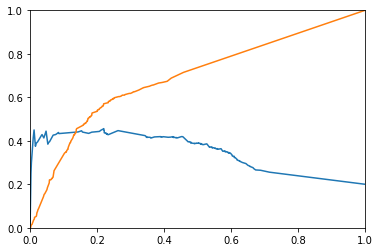

In [269]:
print(precision_recall(y_test, test_label, 0.5))
precision_recall_plot(y_test, test_label)
ROC_plot(y_test, test_label)
plt.show()

(0.5278514588859416, 0.36988847583643125)


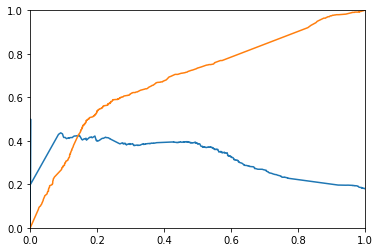

In [270]:
y_test = cnn_model(test_data).cpu()
print(precision_recall(y_test, test_label, 0.5))
precision_recall_plot(y_test, test_label)
ROC_plot(y_test, test_label)
plt.show()

(0.506631299734748, 0.3886063072227874)


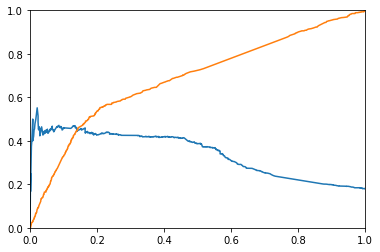

In [271]:
y_test = ann_model(test_data).cpu()
print(precision_recall(y_test, test_label, 0.5))
precision_recall_plot(y_test, test_label)
ROC_plot(y_test, test_label)
plt.show()

In [272]:
y_test = lstm_att_model(test_data.permute(1,0)).cpu()

(0.5464190981432361, 0.3701707097933513)


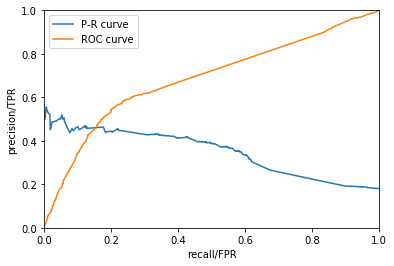

In [273]:
print(precision_recall(y_test, test_label, 0.5))
precision_recall_plot(y_test, test_label,'P-R curve')
ROC_plot(y_test, test_label,'ROC curve')
plt.xlabel('recall/FPR')
plt.ylabel('precision/TPR')
plt.legend()
plt.show()

In [289]:
y_test_lstm = lstm_model(test_data.permute(1,0)).cpu()
y_test_cnn = cnn_model(test_data).cpu()
y_test_ann = ann_model(test_data).cpu()
y_test_lstm_att = lstm_att_model(test_data.permute(1,0)).cpu()


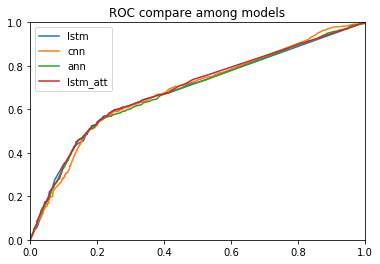

In [290]:
ROC_plot(y_test_lstm, test_label, name = 'lstm')
ROC_plot(y_test_cnn, test_label, name = 'cnn')
ROC_plot(y_test_ann, test_label, name = 'ann')
ROC_plot(y_test_lstm_att, test_label, name = 'lstm_att')
plt.legend()
plt.title('ROC compare among models')
plt.show()

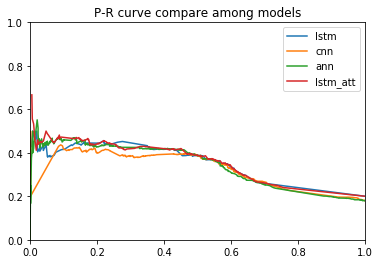

In [291]:
precision_recall_plot(y_test_lstm, test_label, name = 'lstm')
precision_recall_plot(y_test_cnn, test_label, name = 'cnn')
precision_recall_plot(y_test_ann, test_label, name = 'ann')
precision_recall_plot(y_test_lstm_att, test_label, name = 'lstm_att')
plt.legend()
plt.title('P-R curve compare among models')
plt.show()